In [100]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import math
import time
import os
import matplotlib.pylab as plt
from torch.optim import AdamW
import numpy as np
import gc

In [101]:
# set the device we will be using to train the model
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [102]:
device

device(type='cuda', index=1)

In [103]:
# !wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
# !unzip nature_12K.zip

In [104]:
training_data_path = "inaturalist_12K/train/"

In [105]:
class CNN(nn.Module):
    def __init__(
        self,
        input_dimension:tuple,
        number_of_filters: int,
        filter_size: tuple,
        stride: int,
        padding: int,
        max_pooling_size: tuple,
        n_neurons: int,
        n_classes: int,
        conv_activation: nn.Module,
        dense_activation: nn.Module,
        dropout_rate:float,
        use_batchnorm:bool,
        factor:float,
        dropout_organisation:int
    ):
        super().__init__()
        self.conv_blocks = nn.ModuleList([])
        in_c = input_dimension[0]
        for i in range(0, 5):
            add_dropout = i%dropout_organisation > 0
            out_c = int((factor**i)*number_of_filters)
            if out_c<=0:
                out_c = 3
            conv_block = self.create_conv_block(in_c, out_c, filter_size, max_pooling_size, stride, padding, conv_activation, dropout_rate, use_batchnorm, add_dropout)
            self.conv_blocks.append(conv_block)
            in_c = out_c

        self.flatten = nn.Flatten()
        
        r = torch.ones(1, *input_dimension)
        for block in self.conv_blocks:
            block.eval()
            r = block(r)
        in_features = int(np.prod(r.size()[1:]))

        self.dense_block1 = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=n_neurons),
            dense_activation,
            nn.Linear(in_features=n_neurons, out_features=n_classes)
        )

    def create_conv_block(self, in_c, out_c, kernel_size, max_pooling_size, stride, padding, conv_activation, dropout_rate, use_batchnorm, add_dropout):
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
            conv_activation,
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.MaxPool2d(kernel_size=max_pooling_size))
        if add_dropout:
            layers.append(nn.Dropout(p=dropout_rate))
        return nn.Sequential(*layers)


    def __call__(self, x):
        r = x
        for block in self.conv_blocks:
            r = block(r)
        r = self.flatten(r)
        output = self.dense_block1(r)
        return output

In [106]:
def get_transform(use_augmentation):
    if use_augmentation:
        transform = transforms.Compose([
          transforms.RandomCrop(50, padding=1),
          transforms.RandomGrayscale(p=0.1),
          transforms.RandomHorizontalFlip(),
          transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
          transforms.RandomRotation(degrees=(0, 20)),
          transforms.RandomPerspective(distortion_scale=0.5, p=0.5), 
          transforms.CenterCrop(250),
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225],
                                    inplace=False),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225],
                                    inplace=False),
        ])
    return transform

In [107]:
def train(config):
    
    training_data = ImageFolder(root=training_data_path, transform=get_transform(config['use_augmentation']))
    train_size = int(0.8 * len(training_data))
    val_size = len(training_data) - train_size
    train_set, validation_set = random_split(training_data, [train_size, val_size])
    train_dataloader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(validation_set, batch_size=config['batch_size'], shuffle=False)


    training_loss, training_accuracy, validation_loss, validation_accuracy = [],  [],  [], []

    activations = {
      'relu': nn.ReLU(),
      'gelu': nn.GELU(),
      'silu': nn.SiLU(),
      'mish': nn.Mish(),
      'relu6':nn.ReLU6(),
      'tanh': nn.Tanh(),
      'sigmoid': nn.Sigmoid()
    }
    gc.collect()
    torch.cuda.empty_cache()
    model = CNN(
      input_dimension=(3,224,224),
        number_of_filters=config['number_of_filters'],
        filter_size =(config['filter_size'],config['filter_size']),
        stride=config['stride'],
        padding=config['padding'],
        max_pooling_size=(config['max_pooling_size'],config['max_pooling_size']),
        n_neurons=config['n_neurons'],
        n_classes=config['n_classes'],
        conv_activation=activations[config['conv_activation']],
        dense_activation=activations[config['dense_activation']],
        dropout_rate=config['dropout_rate'],
        use_batchnorm=config['use_batchnorm'],
        factor=config['factor'],
        dropout_organisation=config['dropout_organisation']
    ).to(device)
    print(model)
    optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss()

    for epoch in range(0, config['epochs']):

        running_loss, running_accuracy, running_batch = 0,0,0
        model.train()
        for (x, y) in train_dataloader:
            optimizer.zero_grad()
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = criterion(pred, y)
            running_loss += loss.item()*x.size()[0]
            running_accuracy += (pred.argmax(1)==y).sum().item()
            running_batch +=y.size()[0]
            loss.backward()
            optimizer.step()
            del x
            del y
        training_loss.append(running_loss/len(train_dataloader.dataset))
        training_accuracy.append(100*(running_accuracy/running_batch))
        
        running_loss, running_accuracy, running_batch = 0,0,0
        with torch.no_grad():
            model.eval()
            for (x, y) in val_dataloader:
                (x, y) = (x.to(device), y.to(device))
                pred = model(x)
                loss = criterion(pred, y)
                running_loss += loss.item()*x.size()[0]
                running_accuracy += (pred.argmax(1)==y).sum().item()
                running_batch +=y.size()[0]
                del x
                del y
        validation_loss.append(running_loss/len(val_dataloader.dataset))
        validation_accuracy.append(100*(running_accuracy/running_batch))
        
        print(f"Epoch: {epoch+1}/{config['epochs']}")
        gc.collect()
        torch.cuda.empty_cache()
    return model, training_loss, training_accuracy, validation_loss, validation_accuracy

In [108]:
config = {
    'number_of_filters': 32,
    'filter_size': 3,
    'stride': 1,
    'padding': 1,
    'max_pooling_size': 2,
    'n_neurons': 512,
    'n_classes': 10,
    'conv_activation': 'relu',
    'dense_activation': 'relu',
    'dropout_rate': 0.2,
    'use_batchnorm': True,
    'factor':1,
    'learning_rate': 1e-5,
    'batch_size':64,
    'epochs':100,
    'use_augmentation': False,
    'dropout_organisation': 3,
    'weight_decay':1e-2
}

In [109]:
model, training_loss, training_accuracy, validation_loss, validation_accuracy = train(config)

CNN(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0.2, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
     

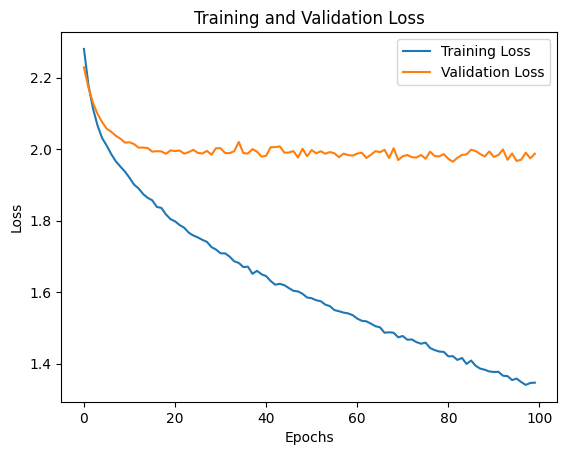

In [110]:
# Plotting
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

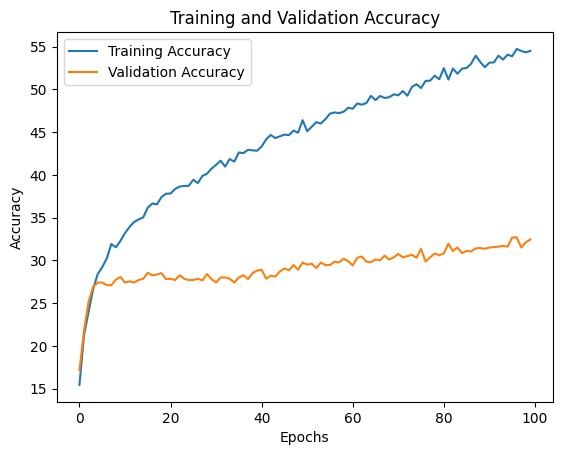

In [111]:
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [113]:
torch.save(model, "custom_cnn.pt")

# Test

In [89]:
test_data_path = "inaturalist_12K/val/"

In [90]:
transform = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False),
])

In [76]:
test_data = ImageFolder(root=test_data_path, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=True)

In [ ]:
def test_model():
    test_loss, test_accuracy = [],  []
    gc.collect()
    torch.cuda.empty_cache()
    criterion = nn.CrossEntropyLoss()
    running_loss, running_accuracy, running_batch = 0,0,0
    with torch.no_grad():
        model.eval()
        for (x, y) in test_dataloader:
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)
            loss = criterion(pred, y)
            running_loss += loss.item()*x.size()[0]
            running_accuracy += (pred.argmax(1)==y).sum().item()
            running_batch +=y.size()[0]
            del x
            del y
    test_loss.append(running_loss/len(val_dataloader.dataset))
    test_accuracy.append(100*(running_accuracy/running_batch))
    gc.collect()
    torch.cuda.empty_cache()

    return test_loss, test_accuracy

In [ ]:
test_loss, test_accuracy = test_model()

In [ ]:
test_loss[0]

In [ ]:
test_accuracy[0]